# Определение возраста покупателей

**Описание проекта**  

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.  

**Описание данных**  

В  распоряжении  папка с изображениями и csv-файл  с двумя колонками: `file_name` и `real_age`.

Проведите исследовательский анализ набора фотографий.  
Подготовьте данные к обучению.  Обучите нейронную сеть и рассчитайте её качество.   
Необходимо достигнуть метрику MAE  меньше 7.

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1/255)
data = datagen.flow_from_dataframe(dataframe=labels, 
                                   directory='/datasets/faces/final_files/',
                                   x_col='file_name', y_col='real_age',
                                   target_size=(150, 150), batch_size=16,
                                   class_mode='raw', 
                                   seed=12345)

Found 7591 validated image filenames.


In [3]:
def get_title(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def df_info(df, title):
    print()
    print('\033[1m' + '\u0332'.join(title) + '\033[0m')
    display(df.head(10))
    print()
    print('Общая информация о', title) 
    print()
    display(df.info())
    print('Всего пропусков в данных', title, 100 - int((len(df.dropna()) * 100 / len(df))) ,'%')
    print()
    print('Размер выборки', labels.shape)

df_info(labels, get_title(labels))


l̲a̲b̲e̲l̲s


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39



Общая информация о labels

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

Всего пропусков в данных labels 0 %

Размер выборки (7591, 2)


Смотрим на распределение объектов по возрасту и диаграмму размаха возраста 

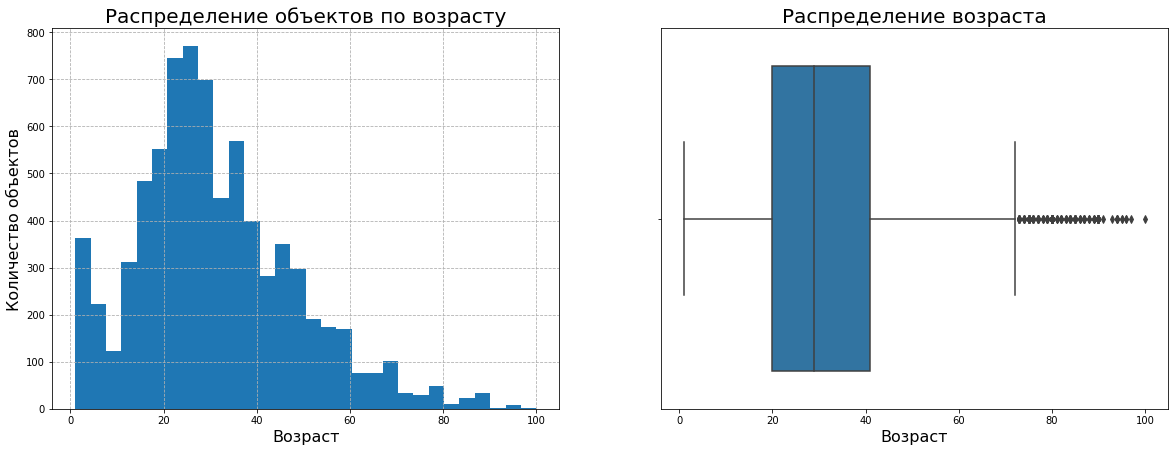

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

labels['real_age'].plot(kind='hist', bins = 30, ax=ax[0])
ax[0].set_title('Распределение объектов по возрасту',fontsize= 20)
ax[0].set_ylabel('Количество объектов',fontsize= 16)
ax[0].set_xlabel('Возраст',fontsize= 16)
ax[0].grid(linestyle = '--')

sns.boxplot(data=labels, x='real_age', ax=ax[1]) 
ax[1].set_xlabel('Возраст',fontsize= 16)
ax[1].set_title('Распределение возраста',fontsize= 20)
ax[0].grid(linestyle = '--')

plt.show()

Смотрим, какие фотографии предоставлены.

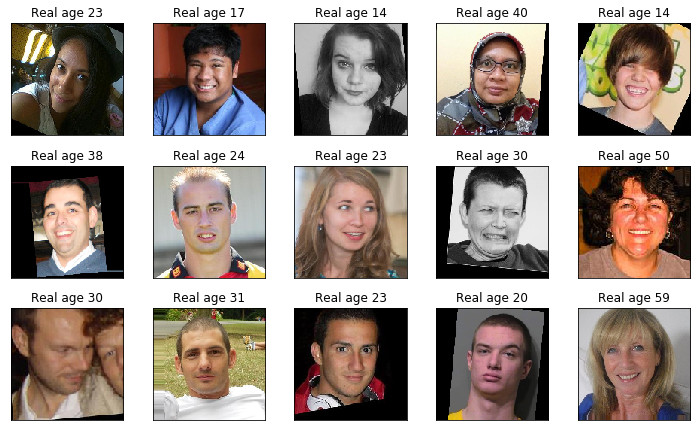

In [14]:
features, target = next(data)
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.title('Real age ' + str(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Наблюдения:**

Данные состоят из 7591 фотографий. Фотографии разных возрастных групп, но их количество для каждой группы неодинаковое.   
Больше всего фотографий объектов в возрасте около 20 - 40 лет, немного детей и ещё меньше старшего возраста.   
Медианный возраст - порядка 30 лет.   
Фотографии разного размера, сделаны с разных ракурсов, содержат посторонние окружающие объекты, перекрывающие порой часть лица, что может создавать дополнительную погрешность для точности модели.

## Обучение модели

Напишем функции, которые разобъют фрейм на обучающую и тестовую выборки и функцию, что сконструирует многослойную нейронную сеть Кeras с оптимизатором Adam.

 
def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255,validation_split=0.25)
    train_data = train_datagen.flow_from_dataframe(dataframe=labels, directory=path+'final_files/', 
                                                   x_col='file_name', y_col='real_age', target_size=(224, 224), 
                                                   batch_size=16, class_mode='raw', subset='training', seed=12345)
    return train_data
 
def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255,validation_split=0.25)
    test_data = test_datagen.flow_from_dataframe(dataframe=labels, directory=path+'final_files/', 
                                                 x_col='file_name', y_col='real_age', target_size=(224, 224), 
                                                 batch_size=16, class_mode='raw', subset='validation', seed=12345)
    return test_data
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,weights='imagenet',include_top=False) 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=Adam(lr=0.0001), loss='mse', metrics=['mae'])
    return model
 
 
def train_model(model, train_data, test_data,
                batch_size=None, epochs=10,
                steps_per_epoch=None,
                validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data, validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True
              )
    return model

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 110s - loss: 198.6824 - mae: 10.2826 - val_loss: 500.3210 - val_mae: 17.2004
Epoch 2/10
356/356 - 37s - loss: 68.7358 - mae: 6.2634 - val_loss: 209.5737 - val_mae: 11.0128
Epoch 3/10
356/356 - 37s - loss: 37.4156 - mae: 4.7014 - val_loss: 68.9091 - val_mae: 6.2570
Epoch 4/10
356/356 - 37s - loss: 22.0032 - mae: 3.6145 - val_loss: 74.5656 - val_mae: 6.6463
Epoch 5/10
356/356 - 37s - loss: 16.2695 - mae: 3.0773 - val_loss: 66.5518 - val_mae: 6.1163
Epoch 6/10
356/356 - 36s - loss: 13.0072 - mae: 2.7479 - val_loss: 74.7832 - val_mae: 6.6852
Epoch 7/10
356/356 - 36s - loss: 11.5993 - mae: 2.5984 - val_loss: 67.8054 - val_mae: 6.1406
Epoch 8/10
356/356 - 36s - loss: 10.0071 - mae: 2.3862 - val_loss: 70.9288 - val_mae: 6.2674
Epoch 9/10
356/356 - 36s - loss: 9.5152 - mae: 2.3355 - val_loss: 75.9993 - val_mae: 6.5379
Epoch 10/10
356/356 - 37s - loss: 9.8473 - mae: 2.3981 - val_loss: 74.1031 - val_mae: 6.3377
119/119 - 9s - loss: 74.1031 - mae: 6.3377
Test MAE: 6.3377
```

## Анализ обученной модели

Провели исследовательский анализ данных. Исходные данные содержали фотографии 7591 объектов, без пропусков и артефактов. Большинство объектов в возрастном диапазоне 20-40 лет.  
Провели предобработку изображений для получения тензора признаков. Яркость изображений выборок привели к диапазону [0, 1], размерность изображений 224х224.  
Модель содержит архитектуру ResNet50 с предобученными на ImageNet сверточными слоями. Для повышения качества обучения в гиперпараметр алгоритма Adam добавили шаг градиентного спуска, с которого алгоритм стартует learning rate = 000.1.

Обученная модель демонстрирует метрику cредней абсолютной ошибки MAE = 6.3377, что меньше обозначенного показателя. 
Основная цель исследования выполнена.

Исходя из задач для бизнеса, обученную модель можно использовать для определения возрастной категории покупетеля и в дальнейшем связывать с рекомендательной системой товаров для полученной возрастной группы. Однако в контроле добросовестности кассиров при продаже алкоголя модель будет менее эффективна, и для этой задачи можно попробовать горизонтальный флип на тренировочной части, что удвоит выборку и, возможно, улучшит результат.